# To do:
    -Efficiently save patch as (patch, lat, lon, features)
    -Store Relevant metadata for each patch
    -Add MESH Target
    -Add Cloud Top Temperature

# Import Statements

In [1]:
# Import packages 
import pandas as pd
import numpy as np
import netCDF4
import h5netcdf
import xarray as xr
from os.path import join
import joblib
from glob import glob
import datetime as dt
import sys
import pyresample
import itertools
from pathlib import Path

#Filters
from scipy.ndimage import uniform_filter, maximum_filter, gaussian_filter

#Custom Packages
sys.path.append('/home/samuel.varga/python_packages/WoF_post') #WoF post package
sys.path.append('/home/samuel.varga/python_packages/wofs_ml_severe/')
sys.path.append('/home/samuel.varga/python_packages/MontePython/')
sys.path.append('/home/samuel.varga/projects/deep_learning/')

from wofs.post.utils import (
    save_dataset,
    load_multiple_nc_files,
)
from main.dl_2to6_data_pipeline import get_files, load_dataset
from collections import ChainMap

#Plotting packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shapely
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from wofs.plotting.wofs_colors import WoFSColors
from wofs_ml_severe.data_pipeline.storm_report_loader import StormReportLoader
%matplotlib inline

lookup_file: /home/samuel.varga/python_packages/WoF_post/wofs/data/psadilookup.dat


In [2]:
from main.MRMSutils import MeshGrabber

# Data Loading

In [3]:
date='20190523'
init_time='0300'

In [4]:
ml_config = { 'ENS_VARS':  ['uh_2to5_instant',
                            'uh_0to2_instant',
                            'wz_0to2_instant',
                            'comp_dz',
                            'ws_80',
                            'hailcast',
                            'w_up',
                            'okubo_weiss',
                            'ctt'
                    ],
             
              'ENV_VARS' : ['mid_level_lapse_rate', 
                            'low_level_lapse_rate', 
                           ],
             
              'SVR_VARS': ['shear_u_0to1', 
                        'shear_v_0to1', 
                        'shear_u_0to6', 
                        'shear_v_0to6',
                        'shear_u_3to6', 
                        'shear_v_3to6',
                        'srh_0to3',
                        'cape_ml', 
                        'cin_ml', 
                        'stp',
                        'scp',
                       ]
            }

In [5]:
data_path=f'/work/mflora/SummaryFiles/{date}/{init_time}'
X_env, X_strm, ncfile, ll_grid  = load_dataset(data_path, TIMESCALE='2to6')

# Plotting Preparation

In [6]:
from wofs.plotting.util import decompose_file_path
dz_levels=np.arange(20,76,5)
cape_levels=np.arange(250,3751,250)
comps = decompose_file_path(ncfile)
start_date=(pd.to_datetime(comps['VALID_DATE']+comps['INIT_TIME'])+dt.timedelta(minutes=int(comps['TIME_INDEX'])*5)) #Beginning of forecast window
end_date=(start_date+dt.timedelta(minutes=240)).strftime('%Y%m%d%H%M') #End of forecast window
start_time=start_date.strftime('%Y%m%d%H%M') 
init_date=(pd.to_datetime(comps['VALID_DATE']+comps['INIT_TIME'])).strftime('%Y%m%d%H%M')

In [7]:
def add_map_stuff(ax, states, shape_feature):
    ax.add_feature(states, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.LAKES, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.COASTLINE, linewidth=.1, facecolor='none', edgecolor="black")        
    ax.add_feature(shape_feature)
    
    
def set_extent(ax, projection , crs, lat, lons,):
    """ Set the Map extent based the WoFS domain """
    # Set the extent. 
    xs, ys, _ = projection.transform_points(
            crs,
            np.array([lons.min(), lons.max()]),
            np.array([lats.min(), lats.max()])).T
    _xlimits = xs.tolist()
    _ylimits = ys.tolist()

    # The limit is max(lower bound), min(upper bound). This will create 
    # a square plot and make sure there is no white spaces between the map
    # the bounding box created by matplotlib. This also allows us to set the
    # WoFS domain boundaries in cases where we aren't plotting WoFS data 
    # (e.g., storm reports, warning polygons, etc.) 
    lims = (max([_xlimits[0]]+[_ylimits[0]]),min([_xlimits[-1]]+[_ylimits[-1]]))
        
    ax.set_xlim(lims)
    ax.set_ylim(lims) 
    
    return ax #0000 is 0000 the next day

In [8]:
ds = xr.load_dataset(ncfile, decode_times=False)
lats = ds['xlat'][::1, ::1]
lons = ds['xlon'][::1, ::1]
base_grid=[lats,lons]
target_grid=[lats[::3, ::3], lons[::3, ::3]]

shape = (len(lons), len(lats))

central_longitude = ds.attrs['STAND_LON']
central_latitude = ds.attrs['CEN_LAT']

standard_parallels = (ds.attrs['TRUELAT1'], ds.attrs['TRUELAT2'])
projection=ccrs.LambertConformal(central_longitude=central_longitude,
                                 central_latitude=central_latitude,
                                 standard_parallels=standard_parallels)
crs = ccrs.PlateCarree()
data_path = '/home/monte.flora/python_packages/WoF_post/wofs/data/'
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces")

county_file = join(data_path,'COUNTIES', 'countyl010g.shp')
reader = shpreader.Reader(county_file)
shape_feature = ShapelyFeature(reader.geometries(),
                               crs, facecolor='none', linewidth=0.2, edgecolor='black', )

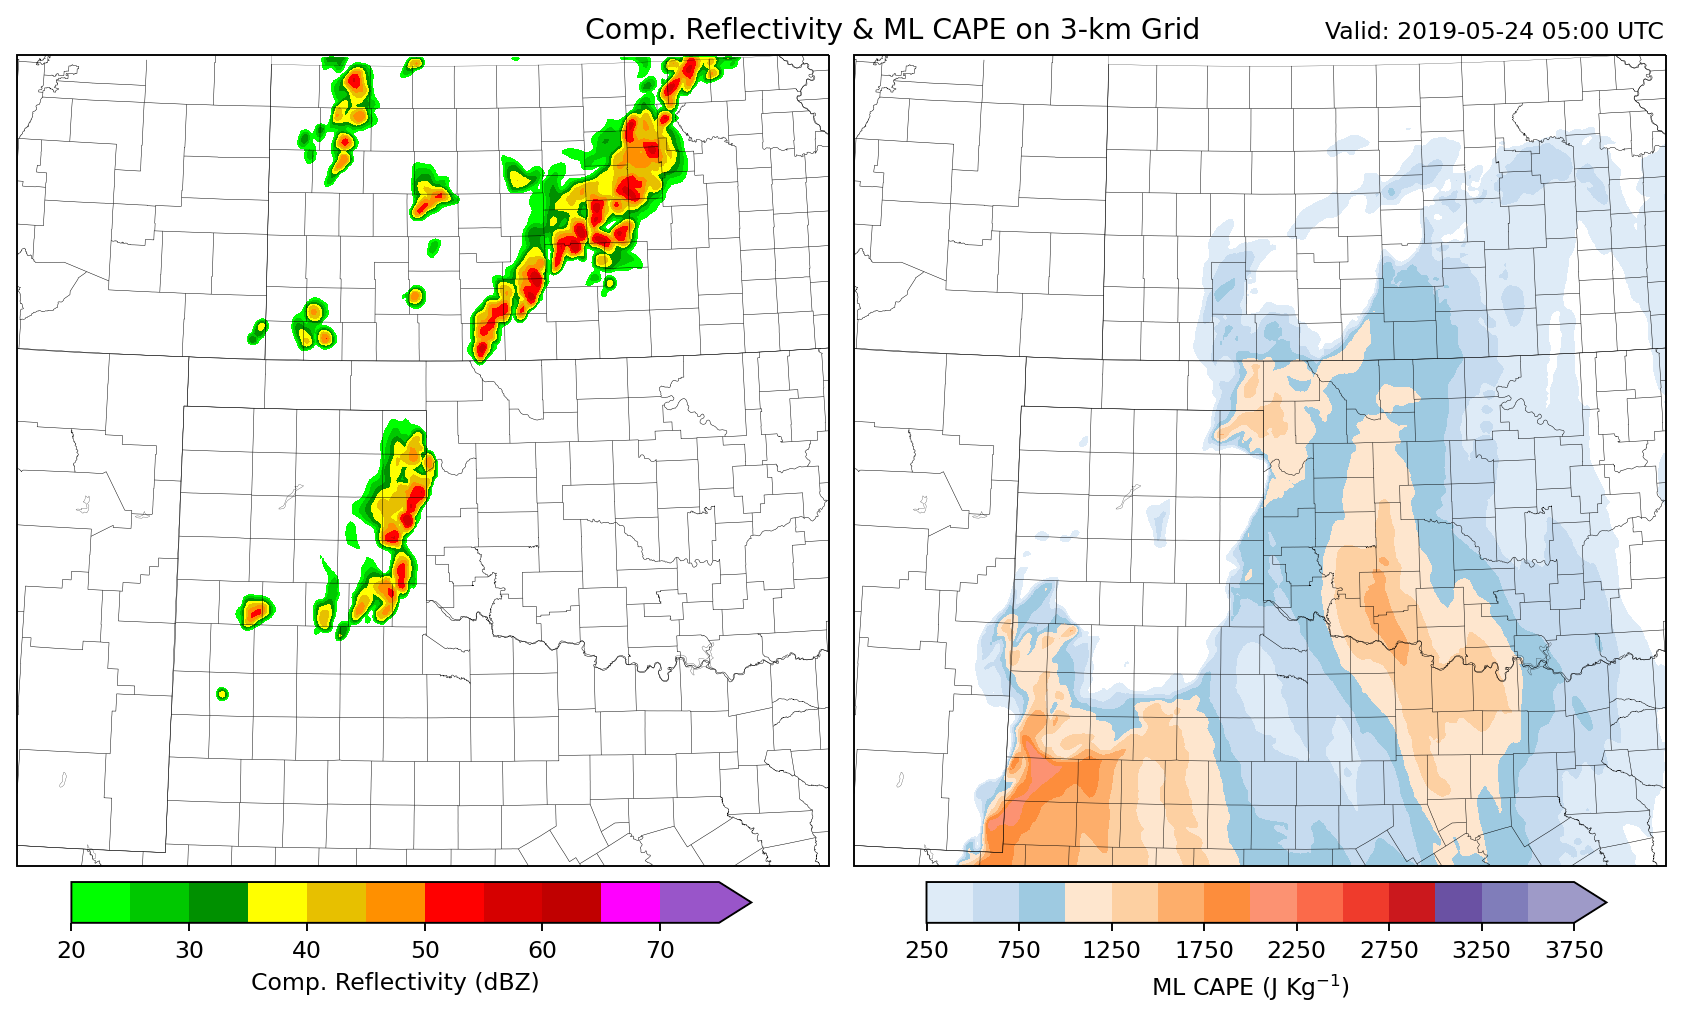

In [9]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=1, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)


levels= [dz_levels, cape_levels]
cmaps=[WoFSColors.nws_dz_cmap, WoFSColors.cape_cmap]
labels=['Comp. Reflectivity (dBZ)', 'ML CAPE (J Kg$^{-1}$)']
title='Comp. Reflectivity & ML CAPE on 3-km Grid'
X_s=[X_strm['comp_dz'][0][0],X_env['cape_ml'][0][0]]
conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[base_grid, base_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

    cf = ax.contourf(grid[1],grid[0], X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
  
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12
    #ax.set_title(f'{name}', fontsize=fontsize)

fig.tight_layout()

cax = [fig.add_axes([0.047, 0.16, 0.4, 0.03]),fig.add_axes([0.55, 0.16, 0.4, 0.03])]
axes[0].annotate(title, (0.7, 1.02), xycoords='axes fraction', fontsize=12, color='k') #(0.7, 1.02)
for cont, ax, label in zip(conts, cax, labels):
      fig.colorbar(cont, cax=ax,label=label, orientation='horizontal', extend='max')
        
#title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} - {end_date[8:10]}:{end_date[10:12]} UTC'        
time_title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} UTC'
axes[1].annotate(time_title, (0.58, 1.02), xycoords='axes fraction', fontsize=10, color='k')
plt.show()

# Patch Extractor

In [10]:
class PatchExtractor:
    """
    Turns a forecast into a 2D predictor field, then returns multiple patches.
    Based heavily on the GridPointExtracter class.
    --------------------------------------------------------------------------
    The PE does the following:
    1) Replaces NaNs with field average and Upscales the Field
    2) Calculates the time composite of every ensemble member
    3) Calculates pointwise ens. statistics to produce predictors
    4) Creates multiple binary target fields from LSR/MRMS data
    5) Returns n patches of predictors and targets from the field
    --------------------------------------------------------------------------
    
    Init Params:
    patch_shape: Diameter of patches given as a tuple of (Y,X)
    
    Class Methods:
    """
    
    def __init__(self, ncfile, env_vars, strm_vars, n_patches, patch_shape,
                forecast_window='2to6',
                target_sizes=[0.5, 2, 4], 
                upscale_size=3, #Coarsens grid by 3x
                grid_spacing=3, #WoFS Grid Spacing (km)
                random_state=42,
                reports_path='/work/mflora/LSRS/StormEvents_2017-2022.csv',
                report_type='NOAA',
                verbose=False
                ):
        
        #Set Object parameters
        self._upscale_size=3
        self._inset = 2 #Number of points to count as "boundary" 
        self._TARGET_SIZES=np.array(np.array(target_sizes)*2, dtype='int') #Convert from radius to diameter
        self._n_ens = 18 #Number of ens. members
        self._env_vars=env_vars
        self._strm_vars=strm_vars
        self._ncfile=ncfile
        self._DX = grid_spacing * self._upscale_size #Delta X of target grid
        self._reports_path = reports_path
        self._report_type = report_type
        self._forecast_window = forecast_window
        self._deltat = 5 #Time step of forecast in minutes
        self._original_grid = ll_grid
        self._target_grid = (self._original_grid[0][::self._upscale_size, ::self._upscale_size],
                             self._original_grid[1][::self._upscale_size, ::self._upscale_size])
        self._n_patches = n_patches #Number of patches to remove
        self._patch_shape = patch_shape #Patch shape in number of grid points (y, x)
        self.verbose=verbose #If true, print extra debug information
        
        
        if np.max(np.absolute(ll_grid[0]))>90:
            raise ValueError('Latitude values for ll_grid exceed 90 and are likely longitude values.')
        np.random.seed(random_state)
        
    def make_dataset(self, X_env, X_strm, predict=False):
        '''Creates the dataset and extracts patches'''
        
        #Apply a Mean filter to environmental fields to upscale them
        X_env_upscaled = {v : self.upscaler(X_env[v], func=uniform_filter,
                        upscale_size=self._upscale_size) for v in self._env_vars}

        
    
        
        #Apply a maximum filter to intrastorm fields to upscale them
        X_strm_upscaled = {v : self.upscaler(X_strm[v], func=maximum_filter,
                            upscale_size=self._upscale_size) for v in self._strm_vars}
         
        
        #Select subset of points based on patches
        X_strm_upscaled, X_env_upscaled=self.extract_patches([X_strm_upscaled, X_env_upscaled]) #{} of (n_patches, n_time, n_ens, y, x)
        
        #Time Composite
        X_env_time_comp=self.calc_time_composite(X_env_upscaled, func=np.nanmean, name='time_avg', keys=self._env_vars, ax=1) #{} of (n_patches, n_ens, y, x)
        X_strm_time_comp=self.calc_time_composite(X_strm_upscaled, func=np.nanmax, name='time_max', keys=self._strm_vars, ax=1)
        
        #Calc Ens. Stats
        X_env_stats=self.calc_ensemble_stats(X_env_time_comp, environ=True) #{} of (n_patches, y, x)
        X_strm_stats=self.calc_ensemble_stats(X_strm_time_comp, environ=False)
        
        
        
        #Add MRMS Comp DZ at t0
        dz = MeshGrabber(self._ncfile, self._upscale_size).load_comp_dz()
        upscaled_dz = {v : self.upscaler(dz, func=maximum_filter,
                            upscale_size=self._upscale_size, is_2d=True) for v in ['MRMS_DZ']}
        upscaled_dz=self.subset_patches([upscaled_dz], is_2D=True)[0]
        return upscaled_dz
    
    
        #Concatenate
        X_all={**X_strm_stats, **X_env_stats, **upscaled_dz}
        
        if predict:
            #Don't Grab Targets
            data = X_all
        else:
            #If targets are available
            y = self.get_targets(timescale=self.forecast_window)
            y = self.extract_patches([y])
            data = {**X_all, **y}
        
        
        #Save patches, patch metadata
        
###########################
## Preprocessing Methods ##
###########################

    def upscaler(self, X, func, upscale_size, is_2d=False):
        '''Applies a spatial filter per ensemble member and timestep and then
        subsamples the grid to reduce the number of grid points'''
        if is_2d:
            new_X = np.zeros((self._target_grid[0].shape[0], self._target_grid[1].shape[1]))
            fill_value = np.nanmean(X)
            X_ = np.nan_to_num(X, nan=fill_value)
            new_X=self.resampler(func(X_, upscale_size))
            
        else:
            new_X = np.zeros((X.shape[0], X.shape[1],
                          self._target_grid[0].shape[0], self._target_grid[1].shape[1]))
            fill_value = np.nanmean(X)
            
            for t,n in itertools.product(range(new_X.shape[0]), range(self._n_ens)):
                X_ = np.nan_to_num(X[t, n, :, :], nan=fill_value)
                new_X[t, n, :, :] = self.resampler(func(X_, upscale_size)) #(Time, ens_member, lat, lon)
        
        return new_X        
    
    def resampler(self, variable):
        '''
        Resamples the original grid to the target grid using a nearest neighborhood approach 
        
        '''
        
        #Create a pyresample object holding the original grid
        orig_def = pyresample.geometry.SwathDefinition(lons=self._original_grid[1], lats=self._original_grid[0])
        
        #Create another pyresample object for the target grid
        targ_def = pyresample.geometry.SwathDefinition(lons=self._target_grid[1], lats=self._target_grid[0])
        
        variable_nearest = pyresample.kd_tree.resample_nearest(orig_def, variable, targ_def, radius_of_influence=50000, fill_value=None)
        
        return variable_nearest
    
    def neighborhooder(self, field, func, size, is_2d=False, fill_method=0):
        '''Apply Neighborhood function. NaN Values are replaced with
        either a 0, or a generic, full-domain average based on fill_method'''
        
        new_field=field.copy()
        fill_value = np.nanmean(field) if str(fill_method)!='0' else 0
        if is_2d:
            for n in range(self._n_ens):
                field_ = np.nan_to_num(field[:,:], nan=fill_value)
                new_field[:,:] = func(field_, size)
        else:
            for n in range(self._n_ens): #Every Ens Member
                field_ = np.nan_to_num(field[n,:,:], nan=fill_value) 
                new_field[n,:,:] = func(field_, size)
        return new_field 
        
    def calc_time_composite(self, X, func, name, keys, ax=0):
        '''Compute the time-composite using the given function'''
        X_time_comp = {f'{v}__{name}' : func(X[v], axis=ax) for v in keys}
        return X_time_comp
    
    def calc_ensemble_stats(self, X, environ=True, ax=0): #Size 1
        '''Compute the ensemble statistics at each grid point
            
            Params:
            --------
            X: dic of variables with shape {variable : [n_ens, lat, lon]}
            environ: flag used to determine which statistics to compute. True if environment, otherwise false.
        '''
        keys = X.keys()
        X_final = []
        
        if environ:
            #Compute Statistics of Env. Variables
            X_ens_mean = {f'{v}__ens_mean' : np.nanmean(X[v], axis=ax) for v in keys}
            X_ens_std = {f'{v}__ens_std' : np.nanstd(X[v], axis=ax, ddof=1) for v in keys}
            X_ens_stats = {**X_ens_mean, **X_ens_std}
        else:
            #Compute Statistics of Storm Variables
            X_ens_mean = {f'{v}__ens_mean' : np.nanmean(X[v], axis=ax) for v in keys}
            #2nd Highest Member
            X_ens_16th = {f'{v}__ens_90th': np.nanpercentile(X[v], 16/18*100, axis=ax, method='higher') for v in keys}
            #2nd Lowest Member
            X_ens_2nd = {f'{v}__ens_10th': np.nanpercentile(X[v], 2/18*100, axis=ax, method='lower') for v in keys}
            #Interquartile range
            X_iqr = {f'{v}__ens_IQR': np.nanpercentile(X[v], 75, axis=ax, method='higher')-np.nanpercentile(X[v], 25, axis=ax, method='lower') for v in keys}
            X_ens_stats={**X_ens_mean, **X_ens_16th, **X_ens_2nd, **X_iqr}
        X_final.append(X_ens_stats)
        X_final = dict(ChainMap(*X_final))
        
        return X_final

###################    
## Patch Methods ##
###################

    def check_patches(self, border_buffer=1):
            '''Checks to ensure that the forecast area can produce the requested number of patches'''
            
            patch_area = np.prod(self._patch_shape)
            total_patch_area=patch_area*self._n_patches
            forecast_area = np.prod(np.shape(self._target_grid[0]))
            self._max_patches = int(np.floor(forecast_area / patch_area))
            
            borderless_domain = (len(self._target_grid[0])-2*border_buffer, len(self._target_grid[0])-2*border_buffer)
            borderless_domain_area = np.prod(borderless_domain)
            
            if total_patch_area <= forecast_area:
                print('\nRequested patches are compatible with domain\n')
            else:
                print(f'\nRequested patches ({self._n_patches},{self._patch_shape[0]},{self._patch_shape[1]}) are incompatible with domain ({len(self._target_grid[0]),len(self._target_grid[1])})\n')
            
            if self.verbose:
                print('Verbose Readout')
                print('------------')
                print(f'Patch (Shape, Area): {self._patch_shape, (patch_area, total_patch_area)}')
                print(f'Forecast (Shape, Area): {np.shape(self._target_grid[0]), forecast_area}')
                print(f'Number of Unused Gridpoints: {forecast_area-total_patch_area}')
                print(f'Percent of Domain Used (%): {100*total_patch_area/forecast_area}')
                
                
                print(f'\nMaximum Number of patches (Area): {np.floor(forecast_area / patch_area)}')
                print(f'Maximum Number of patches (Grid): {np.floor(len(self._target_grid[0])/self._patch_shape[0])**2}')
                print(f'Number of Unused Gridpoints if Max Patches: {int(forecast_area-(np.floor(forecast_area/patch_area)*patch_area))}')
                
                print(f'\nBoundaryless Domain (N={border_buffer}) (Shape, Area): {borderless_domain, borderless_domain_area}')
                print(f'Max Patches in Boundaryless Domain: {np.floor(borderless_domain_area / patch_area)}')
                print(f'No. of Unused Gridpoints if Max Patches in Boundaryless Domain: {int(borderless_domain_area - (np.floor(borderless_domain_area / patch_area)*self._n_patches))}')
                print('------------')
                
    
    def draw_patches(self):
        '''Randomly Selects Patches'''
        patch_inds=[]
        
        #Number of possible patches, starting from top-left corner
        patch_no=np.product(((len(self._target_grid[0])-2*self._inset)//self._patch_shape[0],
                             (len(self._target_grid[1])-2*self._inset)//self._patch_shape[1]))
        
        #Choose n_patches from the possible patches
        patches = np.random.choice(patch_no, self._n_patches, replace=False)
        
        #Create 2D of possible patches
        patch_grid=np.arange(0,patch_no).reshape((len(self._target_grid[0])-2*self._inset)//self._patch_shape[0],
                                                 (len(self._target_grid[1])-2*self._inset)//self._patch_shape[1])
        
        #Find top-left (Y,X) of each patch
        for patch in patches:
            patch_inds.append(np.argwhere(patch_grid==patch).flatten()) #(Y, X)
        
        self._patch_centers = patch_inds
        
        if self.verbose:
            print(patches)
            print(patch_grid)
                
        return None
    
    def get_patch_centers(self):
        '''Converts patch coordinates to center, rather than top-left'''
        patch_centers=[]
        
        #Convert patch_center from top-left bound to center;
        #Doesn't react well to patches with odd dimensions
        for patch_center in self._patch_centers:
            patch_center = (((patch_center[0]*self._patch_shape[0])+self._patch_shape[0]//2)+self._inset,
                            ((patch_center[1]*self._patch_shape[1])+self._patch_shape[1]//2)+self._inset)
            patch_centers.append(patch_center)
        
        self._patch_centers=patch_centers
        
        if self.verbose:
            print(patch_centers)
        return None
    
    def patch_to_grid(self):
        '''Creates 2D grid of same shape as domain. Grid points not belonging to a patch are 
        assigned 0, while grid points belonging to a patch are assigned their patch number. 
        '''
        #Grid of zeroes of same shape as domain
        patch_grid=np.zeros_like(self._target_grid[0], dtype=int)
    
        #Assign patch no. to grid points inside patch
        for i, patch_cent in enumerate(self._patch_centers):
            patch_grid[patch_cent[0]-(self._patch_shape[0]//2):patch_cent[0]+(self._patch_shape[0]//2),
                  patch_cent[1]-(self._patch_shape[1]//2):patch_cent[1]+(self._patch_shape[1]//2)]=i+1
        
        if self.verbose:
            print([patch_cent for patch_cent in self._patch_centers])
            print(patch_grid)
        
        self._patch_grid =  patch_grid
        
        return None
        
    def stack_patches(self, var, is_2D=False):
        '''Finds and Stacks the Patches for a given field'''
        temp = []
        for i in range(1, self._n_patches+1):
            if is_2D:
                temp.append(np.reshape(var[self._patch_grid==i], (self._patch_shape[0], self._patch_shape[1])))
            else:
                temp.append(np.reshape(var[:,:,self._patch_grid==i], (np.shape(var)[0], np.shape(var)[1], self._patch_shape[0], self._patch_shape[1])))
        return np.stack(temp)  
        
    
    def subset_patches(self, data, is_2D=False):
        '''Subsets the data to only include patches, rather than full fields '''
        out=[]
        for var_dic in data:
            out_dic={v : self.stack_patches(var_dic[v], is_2D=is_2D) for v in var_dic.keys()} #Reshapes to be (patches, time, ens, lat, lon)
            out.append(out_dic)
        return out
    
    def extract_patches(self, data=None, gen_patches=True):
        '''Selects and Extracts Patches - calls other patch methods'''
        
        if gen_patches:
            #Check Compatibility of Requested Patches with Domain
            ex.check_patches()

            #Select Patch Locations
            ex.draw_patches()

            #Get Domain Locations of Patches
            ex.get_patch_centers()

            #Map Patches onto Domain
            ex.patch_to_grid()   
        
        #Compress X based on patch_grid
        data_out = ex.subset_patches(data)
       
        return data_out

####################    
## Target Methods ##
####################

    def get_targets(self, timescale):
        '''Convert Storm reports to original grid, then upscale. Same Method used in GridPointExtracter'''
        comps=decompose_file_path(self._ncfile)
        
        #Compute the forecast start time
        start_time=(pd.to_datetime(comps['VALID_DATE']+comps['INIT_TIME'])+dt.timedelta(minutes=int(comps['TIME_INDEX'])*self._deltat)).strftime('%Y%m%d%H%M')
        
        forecast_length=180 if timescale=='0to3' else 240
        
        #(Down)load storm reports
        report = StormReportLoader(
                reports_path = '/work/mflora/LSRS/StormEvents_2017-2022.csv',
                report_type='NOAA',
                initial_time=start_time, 
                forecast_length=forecast_length, 
                err_window=15,               
            )
        
        ds = xr.load_dataset(self._ncfile, decode_times=False)
        
        #Cast reports to original grid. Max filter of upscale size is applied during this step
        report_ds = report.to_grid(dataset=ds, size=self._upscale_size)
        
        keys = list(report_ds.data_vars)
        
        #Upscale to target Grid
        y = {v : report_ds[v].values[::self._upscale_size, ::self._upscale_size] 
             for v in keys}
        
        
        ##Add MESH and Upscale 
        mesh = MeshGrabber(self._ncfile, self._upscale_size)() 
        y.update({'MESH': mesh[::self._upscale_size, ::self._upscale_size]}); keys.append('MESH')
        
        #Force Binary Values
        for v in y.keys():
            y[v][y[v]>0] = 1
        
        y_final = [] 
        
    
        #Coarsen across target sizes
        for size in self._TARGET_SIZES:
            y_nghbrd = {f'{v}__{self._DX*size/2:.0f}km' : self.neighborhooder(y[v], 
                                                                      func=maximum_filter,
                                                                     size=size, is_2d=True) for v in keys}
            y_final.append(y_nghbrd)
            
        
        y_final = dict(ChainMap(*y_final)) 
        
        #Use Hail/Wind/Tornado to create Any-Severe
        for severe, size in itertools.product([False,True],self._TARGET_SIZES):
            y_final.update(self.get_any_severe(y_final, severe, size))
            
        #Subset patches
        #(Subset patches returns a list, hence the 0 index)
        y_final=self.subset_patches([y_final], is_2D=True)[0]
        
        return y_final
    
    def get_any_severe(self, y_dics, sig, size):
        '''Converts all hazards into Any-Severe Grid'''
        y_out = np.stack([y_dics[f'{h}_{"sig_" if sig else ""}severe__{self._DX*size/2:.0f}km'] for h in ['wind','hail','tornado']]) #Need to extend to mesh
        y_out = np.any(y_out, axis=0).astype(int)

        return {f'any_{"sig_" if sig else ""}severe__{self._DX*size/2:.0f}km': y_out}

In [11]:
ex=PatchExtractor(ncfile, X_env.keys(), X_strm.keys(), 10, (16,16), verbose=True)

# Upscale Data and Time Composite

In [12]:
X_strm_upscaled = {v : ex.upscaler(X_strm[v], func=maximum_filter,
                            upscale_size=ex._upscale_size) for v in ex._strm_vars}

In [13]:
X_strm_time_comp=ex.calc_time_composite(X_strm_upscaled, func=np.nanmax, name='time_max', keys=ex._strm_vars)

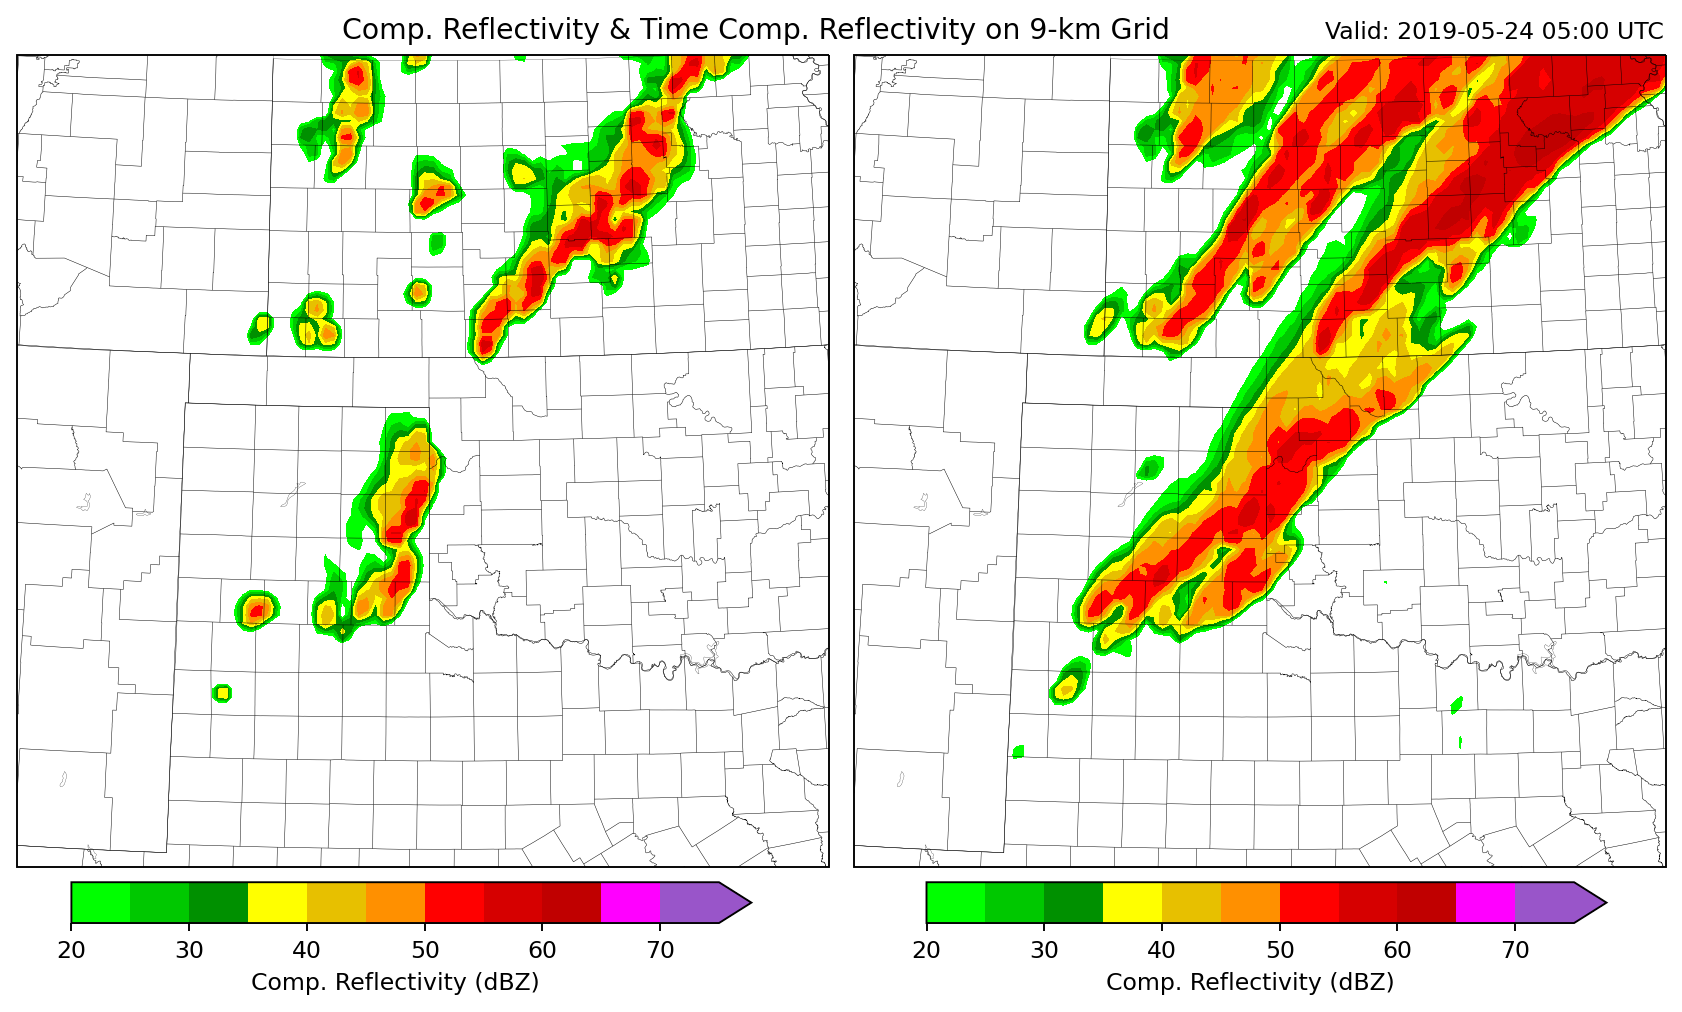

In [14]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=1, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)


levels= [dz_levels, dz_levels]
cmaps=[WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap]
labels=['Comp. Reflectivity (dBZ)', 'Comp. Reflectivity (dBZ)']
title='Comp. Reflectivity & Time Comp. Reflectivity on 9-km Grid'
X_s=[X_strm_upscaled['comp_dz'][0][0],X_strm_time_comp['comp_dz__time_max'][0]]

conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[target_grid, target_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

    cf = ax.contourf(grid[1],grid[0], X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12

fig.tight_layout()

cax = [fig.add_axes([0.047, 0.16, 0.4, 0.03]),fig.add_axes([0.55, 0.16, 0.4, 0.03])]
axes[0].annotate(title, (0.4, 1.02), xycoords='axes fraction', fontsize=12, color='k') #(0.7, 1.02)
for cont, ax, label in zip(conts, cax, labels):
      fig.colorbar(cont, cax=ax,label=label, orientation='horizontal', extend='max')
        

time_title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} UTC'
axes[1].annotate(time_title, (0.58, 1.02), xycoords='axes fraction', fontsize=10, color='k')
plt.show()

# Ens Statistics

In [15]:
X_strm_stats=ex.calc_ensemble_stats(X_strm_time_comp, environ=False)

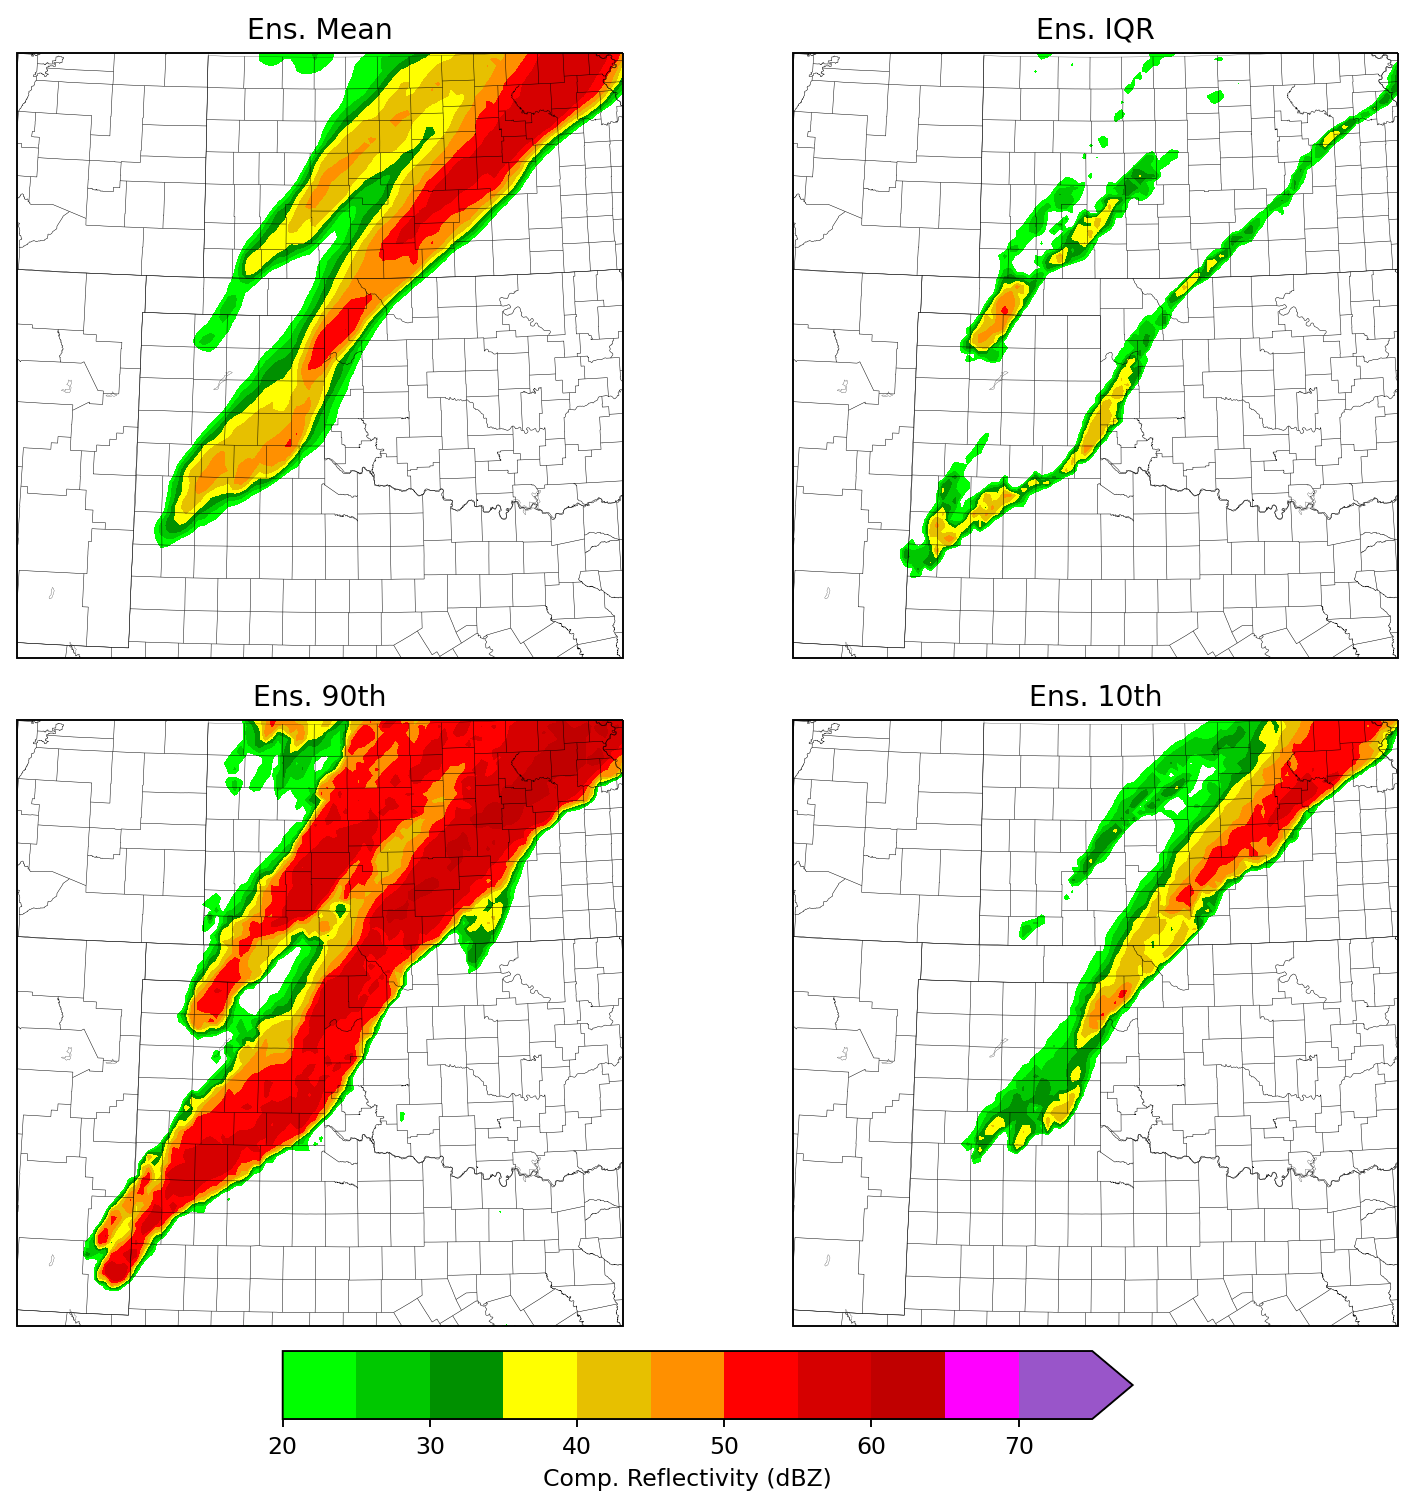

In [16]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)

levels= [dz_levels, dz_levels, dz_levels, dz_levels]
cmaps=[WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap]
labels=['Comp. Reflectivity (dBZ)', 'Comp. Reflectivity (dBZ)','Comp. Reflectivity (dBZ)','Comp. Reflectivity (dBZ)' ]
title='Comp. Reflectivity Ens. Mean & IQR on 9-km Grid'
X_s=[X_strm_stats['comp_dz__time_max__ens_mean'],X_strm_stats['comp_dz__time_max__ens_IQR'],X_strm_stats['comp_dz__time_max__ens_90th'], X_strm_stats['comp_dz__time_max__ens_10th']]

conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[target_grid, target_grid, target_grid, target_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

    cf = ax.contourf(grid[1],grid[0], X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12



cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])        
fig.colorbar(cont, cax=cax,label=label, orientation='horizontal', extend='max')

for ax, l in zip(axes.flat, ['Ens. Mean', 'Ens. IQR', 'Ens. 90th', 'Ens. 10th']):
    ax.set_title(l)

fig.tight_layout()
plt.show()

# Patch Extraction

In [17]:
ex.check_patches(True)


Requested patches are compatible with domain

Verbose Readout
------------
Patch (Shape, Area): ((16, 16), (256, 2560))
Forecast (Shape, Area): ((100, 100), 10000)
Number of Unused Gridpoints: 7440
Percent of Domain Used (%): 25.6

Maximum Number of patches (Area): 39.0
Maximum Number of patches (Grid): 36.0
Number of Unused Gridpoints if Max Patches: 16

Boundaryless Domain (N=True) (Shape, Area): ((98, 98), 9604)
Max Patches in Boundaryless Domain: 37.0
No. of Unused Gridpoints if Max Patches in Boundaryless Domain: 9234
------------


In [18]:
out = ex.extract_patches([X_strm_upscaled])[0] #Generally returns strm, env


Requested patches are compatible with domain

Verbose Readout
------------
Patch (Shape, Area): ((16, 16), (256, 2560))
Forecast (Shape, Area): ((100, 100), 10000)
Number of Unused Gridpoints: 7440
Percent of Domain Used (%): 25.6

Maximum Number of patches (Area): 39.0
Maximum Number of patches (Grid): 36.0
Number of Unused Gridpoints if Max Patches: 16

Boundaryless Domain (N=1) (Shape, Area): ((98, 98), 9604)
Max Patches in Boundaryless Domain: 37.0
No. of Unused Gridpoints if Max Patches in Boundaryless Domain: 9234
------------
[35 13 26 30 16 31 21 12  8 17]
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]
[(90, 90), (42, 26), (74, 42), (90, 10), (42, 74), (90, 26), (58, 58), (42, 10), (26, 42), (42, 90)]
[(90, 90), (42, 26), (74, 42), (90, 10), (42, 74), (90, 26), (58, 58), (42, 10), (26, 42), (42, 90)]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 4 ... 1 0 0]
 [0 0 0 ... 0 0 0]

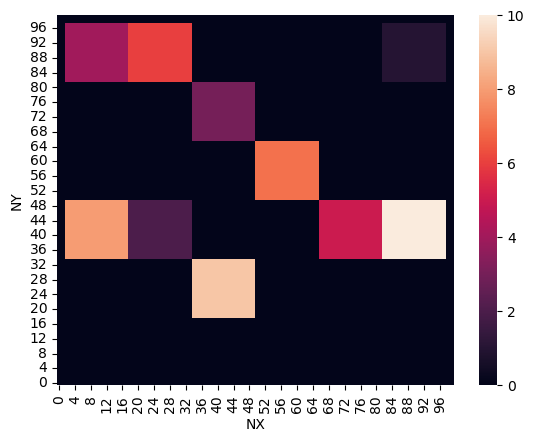

In [19]:
import seaborn as sns
fig, ax = plt.subplots()
sns.heatmap(ex._patch_grid)
ax.invert_yaxis()
ax.set_xlabel('NX')
ax.set_ylabel('NY')
plt.show()

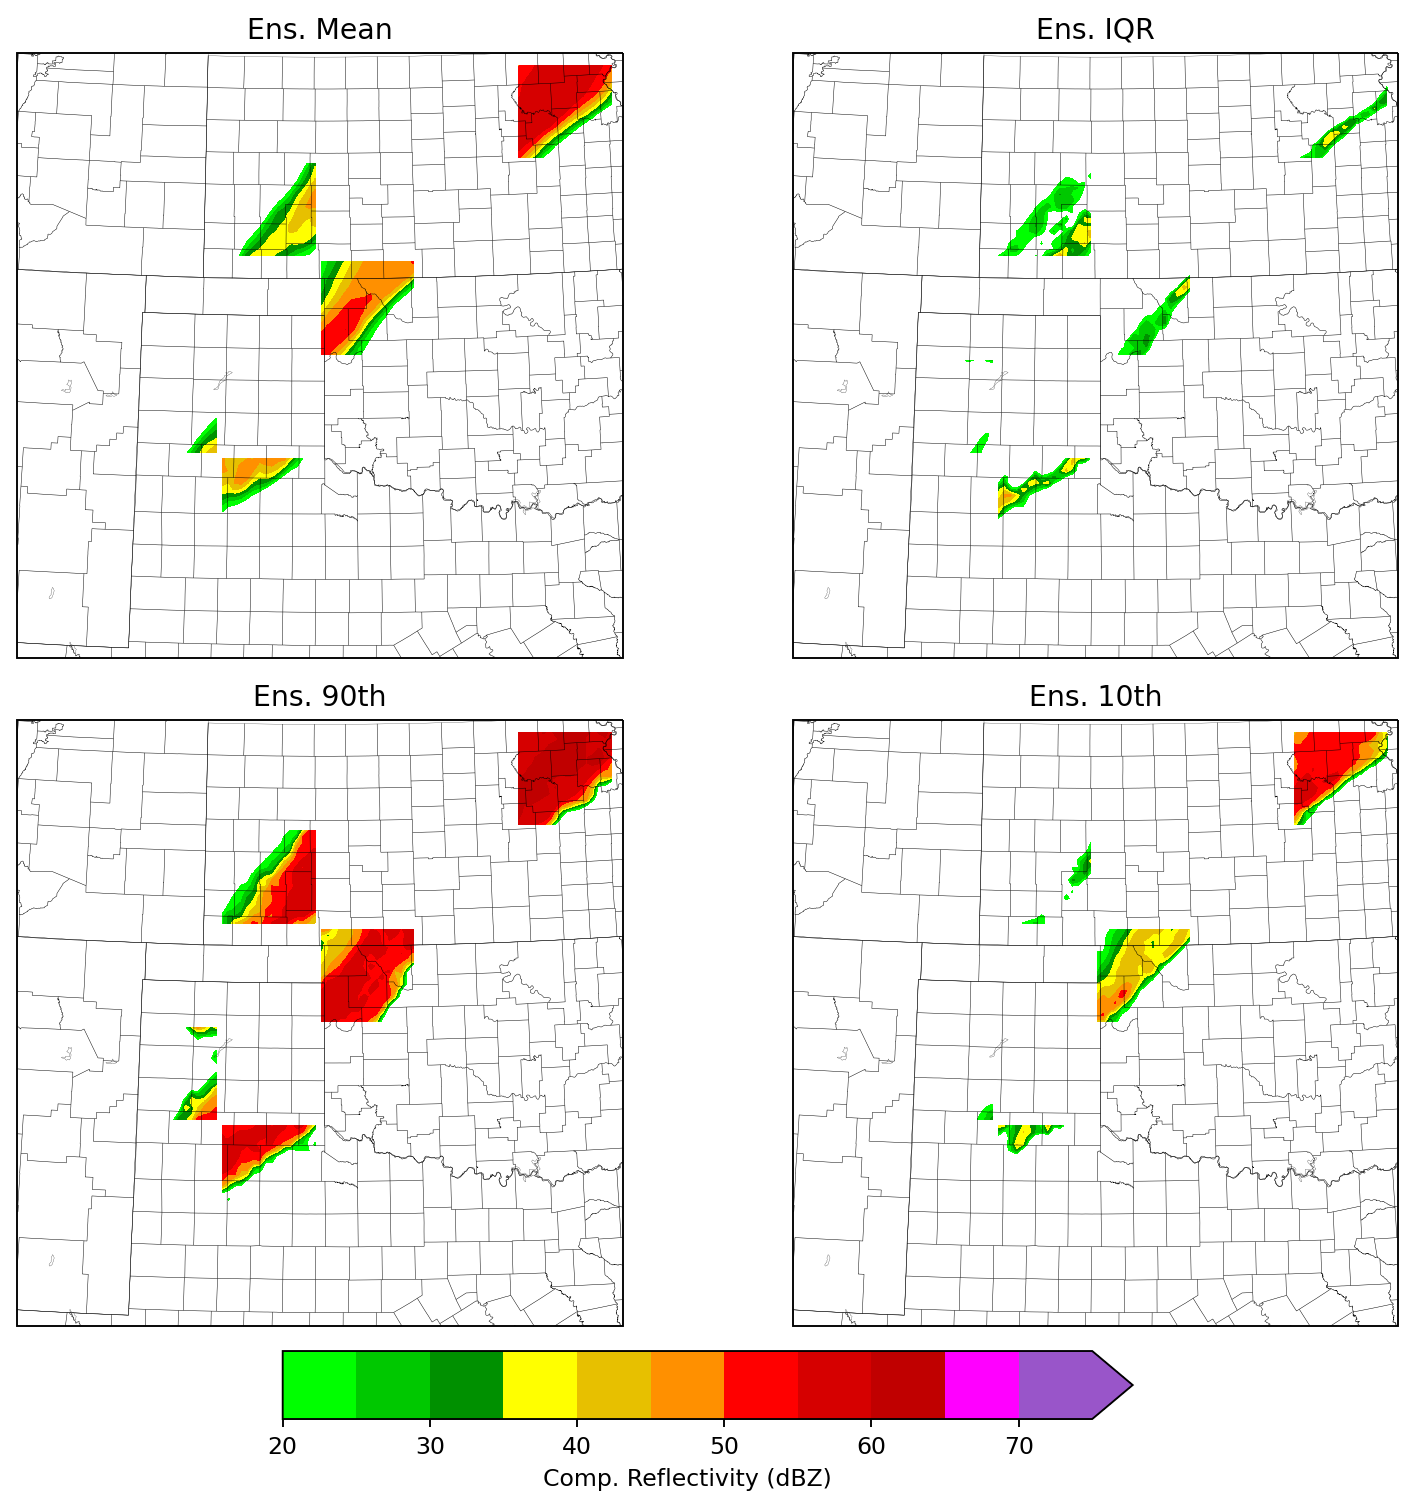

In [20]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)

levels= [dz_levels, dz_levels, dz_levels, dz_levels]
cmaps=[WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap]
labels=['Comp. Reflectivity (dBZ)', 'Comp. Reflectivity (dBZ)','Comp. Reflectivity (dBZ)','Comp. Reflectivity (dBZ)' ]
title='Comp. Reflectivity Ens. Mean & IQR on 9-km Grid'
X_s=[X_strm_stats['comp_dz__time_max__ens_mean'],X_strm_stats['comp_dz__time_max__ens_IQR'],X_strm_stats['comp_dz__time_max__ens_90th'],X_strm_stats['comp_dz__time_max__ens_10th']]

conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[target_grid, target_grid, target_grid, target_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

    #cf = ax.contourf(grid[1],grid[0], np.ma.masked_where(ex._patch_grid[::-1, :]==0, np.ones_like(X)*20), transform = crs, cmap=cmap, levels=level, extend='max')

####
    cf = ax.contourf(grid[1],grid[0], np.ma.masked_where(ex._patch_grid==0, X), transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12



cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])        
fig.colorbar(cont, cax=cax,label=label, orientation='horizontal', extend='max')

for ax, l in zip(axes.flat, ['Ens. Mean', 'Ens. IQR', 'Ens. 90th', 'Ens. 10th']):
    ax.set_title(l)
    
fig.tight_layout()
plt.show()

In [21]:
X_patch_time_comp=ex.calc_time_composite(out, func=np.nanmax, name='time_max', keys=ex._strm_vars, ax=1)
X_patch_stats=ex.calc_ensemble_stats(X_patch_time_comp, environ=False, ax=1)

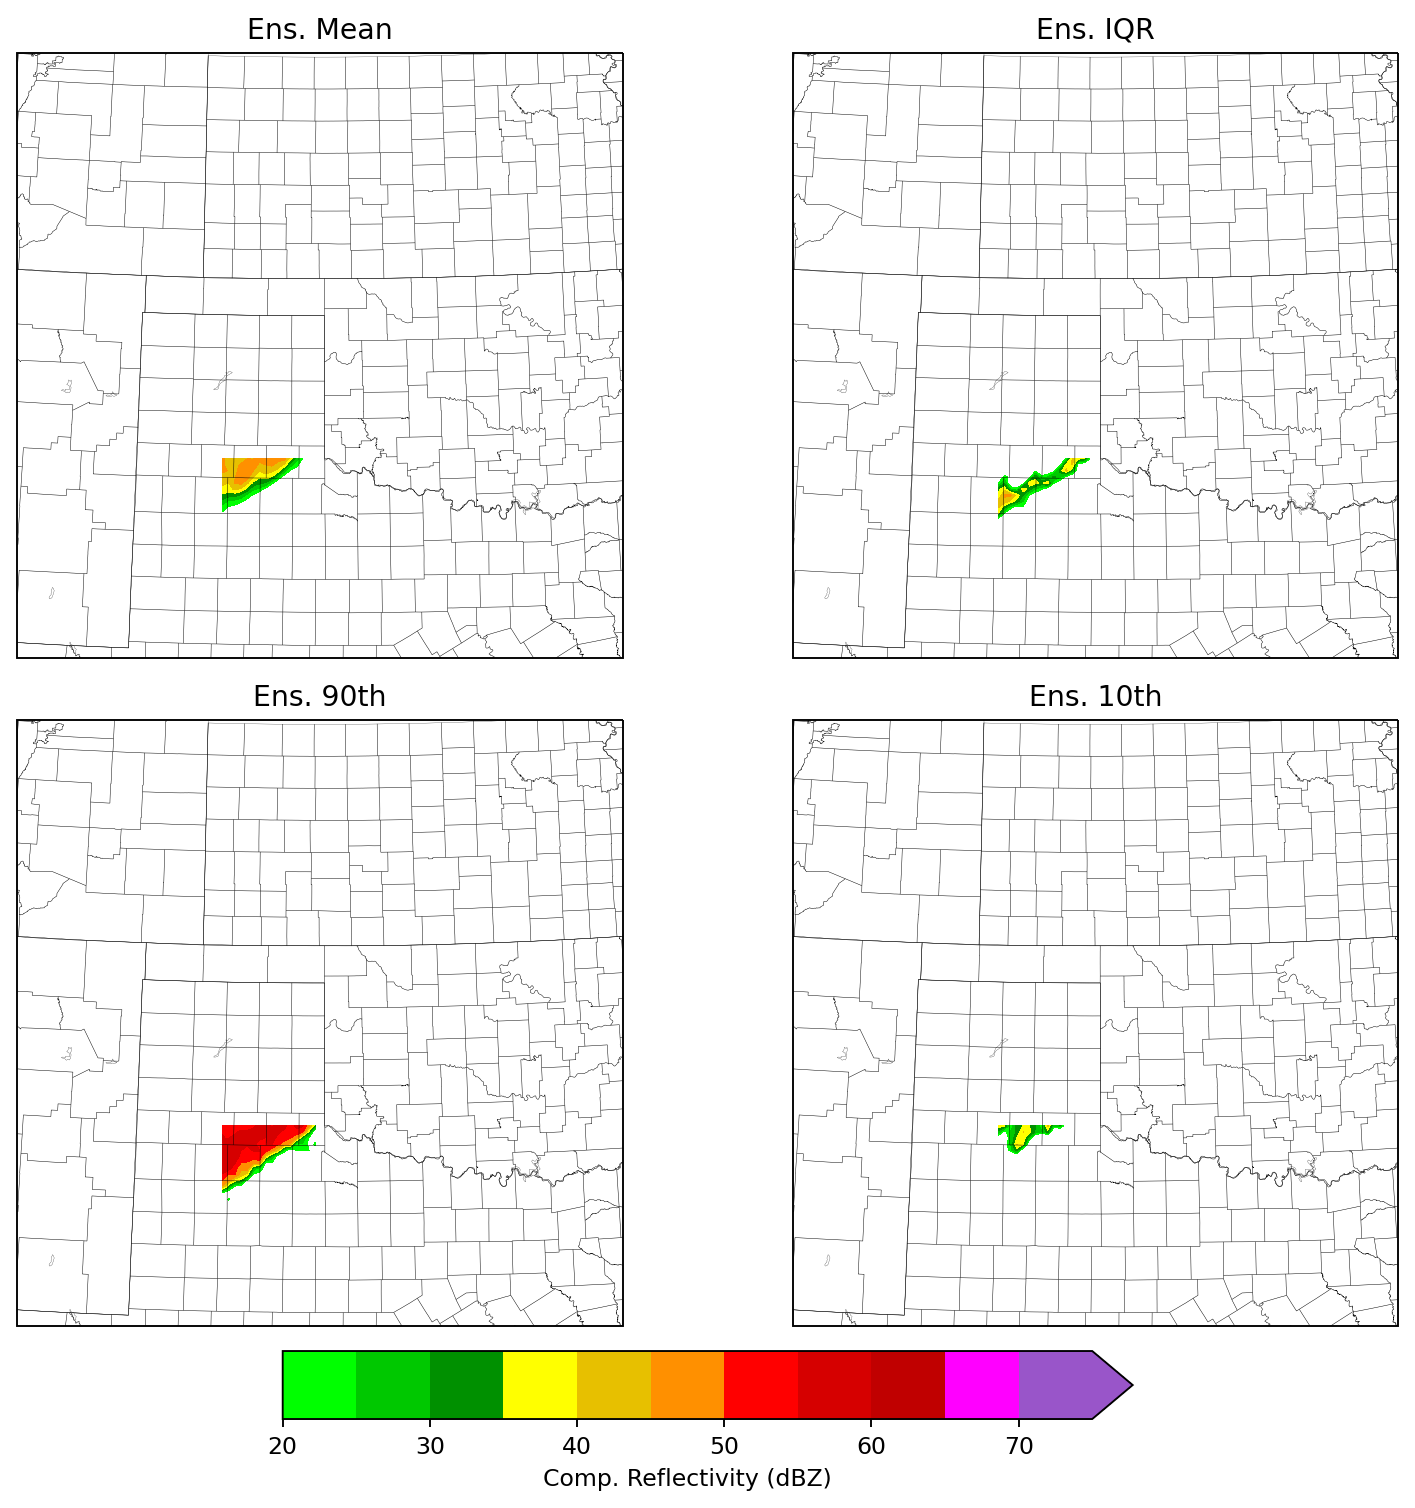

In [22]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)

levels= [dz_levels, dz_levels, dz_levels, dz_levels]
cmaps=[WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap]
labels=['Comp. Reflectivity (dBZ)', 'Comp. Reflectivity (dBZ)','Comp. Reflectivity (dBZ)','Comp. Reflectivity (dBZ)' ]
title='Comp. Reflectivity Ens. Mean & IQR on 9-km Grid'
patch_no=9
X_s=[X_patch_stats['comp_dz__time_max__ens_mean'][patch_no-1],X_patch_stats['comp_dz__time_max__ens_IQR'][patch_no-1],X_patch_stats['comp_dz__time_max__ens_90th'][patch_no-1], X_patch_stats['comp_dz__time_max__ens_10th'][patch_no-1]]

conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[target_grid, target_grid, target_grid, target_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)
    
    lat_bounds = (np.nanmin(np.argwhere(ex._patch_grid==patch_no)[:,0]), np.nanmax(np.argwhere(ex._patch_grid==patch_no)[:,0]))
    lon_bounds = (np.nanmin(np.argwhere(ex._patch_grid==patch_no)[:,1]), np.nanmax(np.argwhere(ex._patch_grid==patch_no)[:,1]))
    sub_grid_y=grid[0][lat_bounds[0]:lat_bounds[-1]+1, lon_bounds[0]:lon_bounds[-1]+1]
    sub_grid_x=grid[1][lat_bounds[0]:lat_bounds[-1]+1, lon_bounds[0]:lon_bounds[-1]+1]
    
    
    cf = ax.contourf(sub_grid_x, sub_grid_y, X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12



cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])        
fig.colorbar(cont, cax=cax,label=label, orientation='horizontal', extend='max')

for ax, l in zip(axes.flat, ['Ens. Mean', 'Ens. IQR', 'Ens. 90th', 'Ens. 10th']):
    ax.set_title(l)
    
fig.tight_layout()
plt.show()

In [23]:
np.shape(X_patch_stats['comp_dz__time_max__ens_mean'])
#Ultimately want shape (patches, Y, X, features)

(10, 16, 16)

In [24]:
y = ex.get_targets(ex._forecast_window)
print(y.keys())

dict_keys(['tornado_severe__36km', 'hail_severe__36km', 'wind_severe__36km', 'tornado_sig_severe__36km', 'hail_sig_severe__36km', 'wind_sig_severe__36km', 'MESH__36km', 'tornado_severe__18km', 'hail_severe__18km', 'wind_severe__18km', 'tornado_sig_severe__18km', 'hail_sig_severe__18km', 'wind_sig_severe__18km', 'MESH__18km', 'tornado_severe__4km', 'hail_severe__4km', 'wind_severe__4km', 'tornado_sig_severe__4km', 'hail_sig_severe__4km', 'wind_sig_severe__4km', 'MESH__4km', 'any_severe__4km', 'any_severe__18km', 'any_severe__36km', 'any_sig_severe__4km', 'any_sig_severe__18km', 'any_sig_severe__36km'])


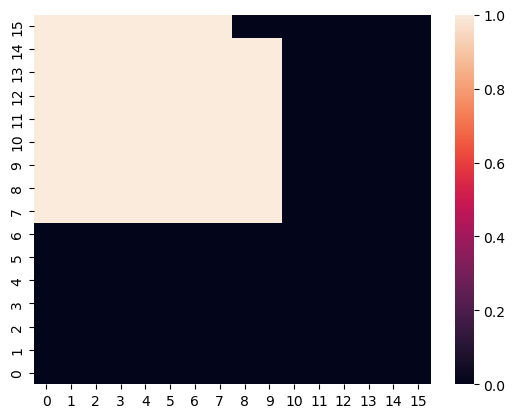

In [25]:
fig, ax =plt.subplots()
sns.heatmap(y['MESH__36km'][8])
ax.invert_yaxis()

In [26]:
mesh = MeshGrabber(ncfile, ex._upscale_size)()#Return boolean, Upscale size
mesh=mesh[::ex._upscale_size, ::ex._upscale_size]
mesh = maximum_filter(mesh, ex._TARGET_SIZES[-1])

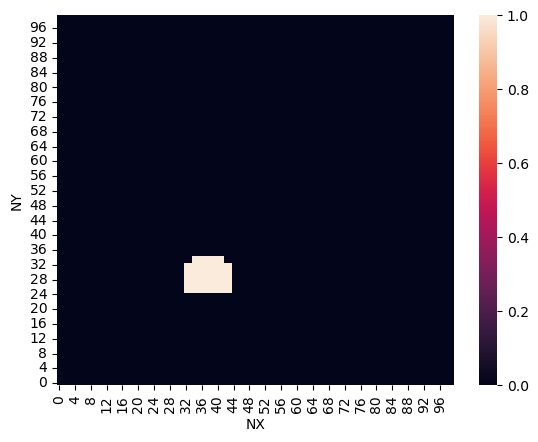

In [27]:
fig, ax = plt.subplots()
sns.heatmap(mesh)
ax.invert_yaxis()
ax.set_xlabel('NX')
ax.set_ylabel('NY')
plt.show()

In [33]:
X_patch_stats.keys()

dict_keys(['uh_2to5_instant__time_max__ens_mean', 'uh_0to2_instant__time_max__ens_mean', 'wz_0to2_instant__time_max__ens_mean', 'comp_dz__time_max__ens_mean', 'ws_80__time_max__ens_mean', 'hailcast__time_max__ens_mean', 'w_up__time_max__ens_mean', 'okubo_weiss__time_max__ens_mean', 'ctt__time_max__ens_mean', 'uh_2to5_instant__time_max__ens_90th', 'uh_0to2_instant__time_max__ens_90th', 'wz_0to2_instant__time_max__ens_90th', 'comp_dz__time_max__ens_90th', 'ws_80__time_max__ens_90th', 'hailcast__time_max__ens_90th', 'w_up__time_max__ens_90th', 'okubo_weiss__time_max__ens_90th', 'ctt__time_max__ens_90th', 'uh_2to5_instant__time_max__ens_10th', 'uh_0to2_instant__time_max__ens_10th', 'wz_0to2_instant__time_max__ens_10th', 'comp_dz__time_max__ens_10th', 'ws_80__time_max__ens_10th', 'hailcast__time_max__ens_10th', 'w_up__time_max__ens_10th', 'okubo_weiss__time_max__ens_10th', 'ctt__time_max__ens_10th', 'uh_2to5_instant__time_max__ens_IQR', 'uh_0to2_instant__time_max__ens_IQR', 'wz_0to2_instant

In [29]:
#Ways to do buffer offset:
#Mask the patches along the boundary, then subsample from that compressed/masked array

#When creating the patch, pass the random sampler 2::-2? 

In [30]:
#Find n_files, generate n ints to use as random state, Pass in the random state
#Return Metadata that is [NY, NX, patch_no] where [NY, NX] correspond to gridpoints on unsubsampled grid
#Save patch method and shape in DS file name

#Convert Input to: (patch, Y, X, features) #Need to know how features mapped into array
#Convert Output to: {type : (patch, Y, X)}
#Convert metadata to: (patch, Y, X, (init date, init_time, local_patch_no, NY, NX))

#That way, everything can be stacked along axis=0.
#Might Have to find more efficient way to save output? Stacking might be a pain